In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, zipfile

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [3]:
zip_path = "/content/Dataset_fibro.zip"
extract_all_dir = "/content/Gastrovision"
filtered_output_dir = "/content/Dataset_fibro"

malade_classes = [
    "Colorectal cancer", "Ulcer", "Esophagitis", "Gastric polyps", "Mucosal inflammation"
]
sain_classes = [
    "Normal mucosa", "Normal stomach", "Pylorus"
]
selected_classes = malade_classes + sain_classes


In [4]:
print("Extraction du fichier zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_all_dir)
print("Extraction terminée.")

Extraction du fichier zip...
Extraction terminée.


In [5]:
print("Copie des dossiers sélectionnés...")
for root, dirs, files in os.walk(extract_all_dir):
    for class_name in selected_classes:
        class_path = os.path.join(root, class_name)
        if os.path.isdir(class_path):
            dest_path = os.path.join(filtered_output_dir, class_name)
            shutil.copytree(class_path, dest_path, dirs_exist_ok=True)
            print(f" Copié : {class_name}")
    break

print("Dataset réduit créé dans :", filtered_output_dir)

Copie des dossiers sélectionnés...
Dataset réduit créé dans : /content/Dataset_fibro


In [6]:
original_root = "/content/Gastrovision/Dataset_fibro"
flat_root = "/content/dataset_fibro_flat"
os.makedirs(flat_root, exist_ok=True)

for super_class in os.listdir(original_root):
    super_class_path = os.path.join(original_root, super_class)
    if os.path.isdir(super_class_path):
        for class_name in os.listdir(super_class_path):
            src_class_path = os.path.join(super_class_path, class_name)
            dst_class_path = os.path.join(flat_root, class_name)
            if os.path.isdir(src_class_path):
                shutil.copytree(src_class_path, dst_class_path, dirs_exist_ok=True)
                print(f" Classe copiée : {class_name}")

 Classe copiée : Normal mucosa and vascular pattern in the large bowel
 Classe copiée : Normal stomach
 Classe copiée : Pylorus
 Classe copiée : Mucosal inflammation large bowel
 Classe copiée : Colorectal cancer
 Classe copiée : Gastric polyps
 Classe copiée : Esophagitis
 Classe copiée : Ulcer


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

DATA_DIR = flat_root

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

# === CLASS WEIGHTS ===
y_train = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Found 2544 images belonging to 8 classes.
Found 631 images belonging to 8 classes.
Class Weights: {0: np.float64(2.8392857142857144), 1: np.float64(3.697674418604651), 2: np.float64(6.115384615384615), 3: np.float64(13.25), 4: np.float64(0.2708688245315162), 5: np.float64(0.4097938144329897), 6: np.float64(1.0095238095238095), 7: np.float64(63.6)}


In [8]:
# === CALLBACKS ===
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_model_densenet.h5", monitor='val_loss', save_best_only=True, verbose=1)

In [9]:
from tensorflow.keras.applications import DenseNet121

# === Phase 1: entraînement de la tête ===
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights_dict
)

# === Phase 2: fine-tuning ===
base_model.trainable = True
for layer in base_model.layers[:100]:  # Gèle partiellement
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2870 - loss: 2.4580
Epoch 1: val_loss improved from inf to 1.28826, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 608s 7s/step - accuracy: 0.2877 - loss: 2.4575 - val_accuracy: 0.4802 - val_loss: 1.2883 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3692 - loss: 1.7460
Epoch 2: val_loss did not improve from 1.28826
80/80 ━━━━━━━━━━━━━━━━━━━━ 595s 7s/step - accuracy: 0.3697 - loss: 1.7451 - val_accuracy: 0.3233 - val_loss: 1.4759 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4739 - loss: 1.9432
Epoch 3: val_loss did not improve from 1.28826
80/80 ━━━━━━━━━━━━━━━━━━━━ 561s 7s/step - accuracy: 0.4740 - loss: 1.9387 - val_accuracy: 0.3803 - val_loss: 1.3566 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5063 - loss: 1.1075
Epoch 4: val_loss did not improve from 1.28826
80/80 ━━━━━━━━━━━━━━━━━━━━ 557s 7s/step - accuracy: 0.5062 - loss: 1.1116 - val_accuracy: 0.2441 - val_loss: 1.7365 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step -

80/80 ━━━━━━━━━━━━━━━━━━━━ 556s 7s/step - accuracy: 0.4597 - loss: 1.4851 - val_accuracy: 0.5151 - val_loss: 1.2623 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5676 - loss: 1.1754
Epoch 6: val_loss improved from 1.26234 to 0.99610, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 589s 7s/step - accuracy: 0.5674 - loss: 1.1773 - val_accuracy: 0.6434 - val_loss: 0.9961 - learning_rate: 0.0010
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5718 - loss: 1.3208
Epoch 7: val_loss did not improve from 0.99610
80/80 ━━━━━━━━━━━━━━━━━━━━ 586s 7s/step - accuracy: 0.5717 - loss: 1.3214 - val_accuracy: 0.6450 - val_loss: 1.0034 - learning_rate: 0.0010
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5665 - loss: 1.2491
Epoch 8: val_loss did not improve from 0.99610
80/80 ━━━━━━━━━━━━━━━━━━━━ 549s 7s/step - accuracy: 0.5664 - loss: 1.2480 - val_accuracy: 0.5689 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5809 - loss: 1.0307
Epoch 9: val_loss improved from 0.99610 to 0.88240, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 550s 7s/step - accuracy: 0.5807 - loss: 1.0320 - val_accuracy: 0.6846 - val_loss: 0.8824 - learning_rate: 0.0010
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5898 - loss: 1.1486
Epoch 10: val_loss did not improve from 0.88240
80/80 ━━━━━━━━━━━━━━━━━━━━ 583s 7s/step - accuracy: 0.5898 - loss: 1.1483 - val_accuracy: 0.6498 - val_loss: 0.9325 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.
Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5268 - loss: 1.2307 
Epoch 1: val_loss improved from 0.88240 to 0.52543, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1224s 14s/step - accuracy: 0.5276 - loss: 1.2311 - val_accuracy: 0.8415 - val_loss: 0.5254 - learning_rate: 1.0000e-04
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7125 - loss: 0.6580 
Epoch 2: val_loss improved from 0.52543 to 0.50593, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1122s 14s/step - accuracy: 0.7127 - loss: 0.6590 - val_accuracy: 0.8225 - val_loss: 0.5059 - learning_rate: 1.0000e-04
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7638 - loss: 0.7215 
Epoch 3: val_loss did not improve from 0.50593
80/80 ━━━━━━━━━━━━━━━━━━━━ 1119s 14s/step - accuracy: 0.7635 - loss: 0.7205 - val_accuracy: 0.7496 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7923 - loss: 0.3775 
Epoch 4: val_loss did not improve from 0.50593
80/80 ━━━━━━━━━━━━━━━━━━━━ 1117s 14s/step - accuracy: 0.7925 - loss: 0.3779 - val_accuracy: 0.7718 - val_loss: 0.6139 - learning_rate: 1.0000e-04
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8237 - loss: 0.3400 
Epoch 5: val_loss did not improve from 0.50593
80/80 ━━━━━━━━━━━━━━━━━━━━ 1081s 14s/step - accuracy: 0.8238 - loss: 0.3403 - val_accuracy: 0.7750 - val_loss: 0.6243 - learning_rate: 1.0000e-04
Epoch 6/100
80/80

80/80 ━━━━━━━━━━━━━━━━━━━━ 1085s 14s/step - accuracy: 0.8458 - loss: 0.2881 - val_accuracy: 0.8463 - val_loss: 0.4888 - learning_rate: 5.0000e-05
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8667 - loss: 0.3564 
Epoch 8: val_loss did not improve from 0.48879
80/80 ━━━━━━━━━━━━━━━━━━━━ 1090s 14s/step - accuracy: 0.8666 - loss: 0.3560 - val_accuracy: 0.8352 - val_loss: 0.5149 - learning_rate: 5.0000e-05
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8632 - loss: 0.2638 
Epoch 9: val_loss did not improve from 0.48879
80/80 ━━━━━━━━━━━━━━━━━━━━ 1087s 14s/step - accuracy: 0.8634 - loss: 0.2635 - val_accuracy: 0.8415 - val_loss: 0.5056 - learning_rate: 5.0000e-05
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8789 - loss: 0.2103 
Epoch 10: val_loss improved from 0.48879 to 0.48220, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1122s 14s/step - accuracy: 0.8790 - loss: 0.2104 - val_accuracy: 0.8542 - val_loss: 0.4822 - learning_rate: 5.0000e-05
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8875 - loss: 0.1958 
Epoch 11: val_loss improved from 0.48220 to 0.47035, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1091s 14s/step - accuracy: 0.8876 - loss: 0.1959 - val_accuracy: 0.8526 - val_loss: 0.4704 - learning_rate: 5.0000e-05
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8975 - loss: 0.2198 
Epoch 12: val_loss did not improve from 0.47035
80/80 ━━━━━━━━━━━━━━━━━━━━ 1134s 14s/step - accuracy: 0.8976 - loss: 0.2195 - val_accuracy: 0.8494 - val_loss: 0.4716 - learning_rate: 5.0000e-05
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9052 - loss: 0.1694 
Epoch 13: val_loss did not improve from 0.47035
80/80 ━━━━━━━━━━━━━━━━━━━━ 1090s 14s/step - accuracy: 0.9052 - loss: 0.1695 - val_accuracy: 0.8431 - val_loss: 0.4708 - learning_rate: 5.0000e-05
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9010 - loss: 0.1530 
Epoch 14: val_loss improved from 0.47035 to 0.41683, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1090s 14s/step - accuracy: 0.9012 - loss: 0.1528 - val_accuracy: 0.8653 - val_loss: 0.4168 - learning_rate: 5.0000e-05
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9301 - loss: 0.1104 
Epoch 15: val_loss improved from 0.41683 to 0.37826, saving model to best_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1099s 14s/step - accuracy: 0.9301 - loss: 0.1105 - val_accuracy: 0.8796 - val_loss: 0.3783 - learning_rate: 5.0000e-05
Epoch 16/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9306 - loss: 0.1133 
Epoch 16: val_loss did not improve from 0.37826
80/80 ━━━━━━━━━━━━━━━━━━━━ 1088s 14s/step - accuracy: 0.9307 - loss: 0.1133 - val_accuracy: 0.8716 - val_loss: 0.4056 - learning_rate: 5.0000e-05
Epoch 17/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9220 - loss: 0.1244 
Epoch 17: val_loss did not improve from 0.37826
80/80 ━━━━━━━━━━━━━━━━━━━━ 1127s 14s/step - accuracy: 0.9221 - loss: 0.1244 - val_accuracy: 0.8605 - val_loss: 0.4351 - learning_rate: 5.0000e-05
Epoch 18/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9325 - loss: 0.0999 
Epoch 18: val_loss did not improve from 0.37826
80/80 ━━━━━━━━━━━━━━━━━━━━ 1090s 14s/step - accuracy: 0.9324 - loss: 0.0999 - val_accuracy: 0.8859 - val_loss: 0.3900 - learning_rate: 5.0000e-05
Epoch 19/10

80/80 ━━━━━━━━━━━━━━━━━━━━ 1095s 14s/step - accuracy: 0.9505 - loss: 0.0759 - val_accuracy: 0.9002 - val_loss: 0.3396 - learning_rate: 2.5000e-05
Epoch 23/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9584 - loss: 0.0674 
Epoch 23: val_loss did not improve from 0.33957
80/80 ━━━━━━━━━━━━━━━━━━━━ 1095s 14s/step - accuracy: 0.9584 - loss: 0.0674 - val_accuracy: 0.8891 - val_loss: 0.4013 - learning_rate: 2.5000e-05
Epoch 24/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9702 - loss: 0.0573 
Epoch 24: val_loss did not improve from 0.33957
80/80 ━━━━━━━━━━━━━━━━━━━━ 1088s 14s/step - accuracy: 0.9701 - loss: 0.0574 - val_accuracy: 0.8875 - val_loss: 0.3842 - learning_rate: 2.5000e-05
Epoch 25/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9658 - loss: 0.0614 
Epoch 25: val_loss did not improve from 0.33957
80/80 ━━━━━━━━━━━━━━━━━━━━ 1083s 14s/step - accuracy: 0.9657 - loss: 0.0614 - val_accuracy: 0.8970 - val_loss: 0.3684 - learning_rate: 2.5000e-05
Epoch 26/10

In [12]:
model.save("my_model.keras")

In [16]:
model.export("my_model_tf")

Saved artifact at 'my_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136062840011856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833068176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833066256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833067408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833067792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833068752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833068368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062840011664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062840011472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833070096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136062833072016: Te

In [17]:
!zip -r my_model_tf.zip my_model_tf
from google.colab import files
files.download("my_model_tf.zip")

  adding: my_model_tf/ (stored 0%)
  adding: my_model_tf/variables/ (stored 0%)
  adding: my_model_tf/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: my_model_tf/variables/variables.index (deflated 79%)
  adding: my_model_tf/assets/ (stored 0%)
  adding: my_model_tf/saved_model.pb (deflated 91%)
  adding: my_model_tf/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

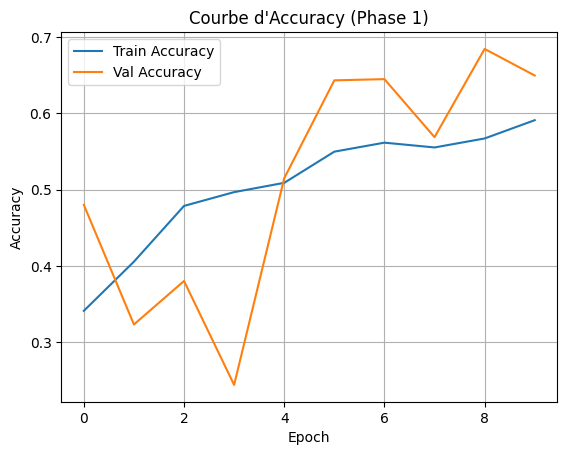

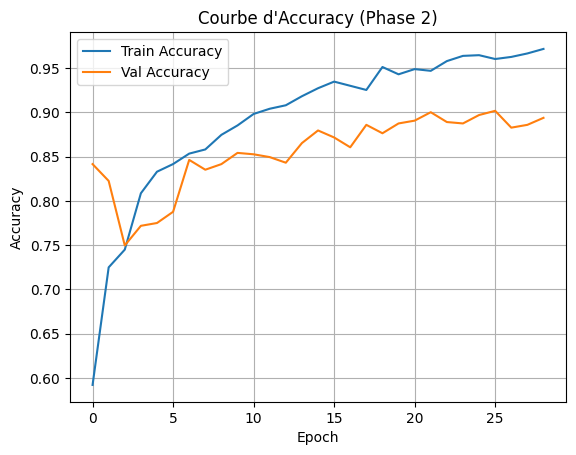

In [14]:
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Courbe d\'Accuracy (Phase 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Courbe d\'Accuracy (Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()